# Boltzmann mean field game solver

We consider the time-dependent BMFG with diffusion on a bounded domain $\Omega = [0,\bar{z}]$. The dynamics are given by
\begin{align*}
&\partial_t f(z,t) - \frac{\sigma^2}{2} \partial_{zz} f(z,t) = f(z,t) \int_0^z \alpha(S(y,t)) f(y,t) dy - \alpha(S(z,t)) f(z,t) \int_z^{\bar{z}} f(y,t) dy\\
&\partial_t V(z,t) - r V(z,t) + \frac{\sigma^2}{2} \partial_{zz} V(z,t) =
(1-S(z,t)) z + \alpha(S(z,t)) \int_{z}^{\infty} \left[V(y,t) - V(z,t) \right] f(y,t) dy\\
&S(z,t) = \text{argmin}_{s\in\mathcal{S}} \left[(1-S(z,t)) z + \alpha(S(z,t)) \int_{z}^{\infty} \left[V(y,t) - V(z,t) \right] f(y,t) dy\right]
\end{align*}
with initial condition $f(z,0) = f_0(z)$ and terminal condition $V(z,T) = 0$. 

We solve the system using a fixed point iteration:
<ol type="a">
  <li> Solve the Boltzmann type equation for given $\alpha_k$ forward in time.</li>
  <li> Solve the HJP for the updated $f_{k+1}$ backward in time to obtain $v_{k+1}$ and the corresponding fraction of time spent on learning $S^{k+1}$.</li>
  <li> Repeat until convergence (hopefully).</li>
</ol>

References:
<ol type="a">
  <li> R. Lucas and B. Moll, {\em Knowledge growth and allocation of time} Journal of Political Economy, 122(1), 2014.</li>
  <li>  Y. Achdou, F. J. Buera, J.-M. Lasry, P.-L. Lions, and B. Moll. {\em Partial differential equation models inmacroeconomics}.Philosophical Transactions of the Royal Society of London A: Mathematical, Physicaland Engineering Sciences, 372(2028), 2014 </li>
</ol>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import scipy.sparse as sparse
import scipy.sparse.linalg


### FD discretization of the Boltzmann type and HJB equation
We define the system matrizes for the PDE solvers - we use a semi-implicit in time discretization. The diffusion is treated implicitely (as well as the temporal decay term in the HJB), while the rhs of the PDEs are computed using the previous iterate in time. Note that it would be better to implement geometric diffusion, as suggested by Lucas&Moll and Lorz et al. All integrals are computed using a trapezoidal rule.

In [2]:
def SetupMatricesDiff(x,npoints,dx,dt,r,sig):
    e = np.ones(npoints)
    m = sparse.identity(npoints)

    data1 = np.stack((e,-2.0 * e,e))
    data1[2,1] = 2.0
    data1[0,npoints-2] = 2.0
    diags1 = [-1,0,1]
    diffusion = sparse.spdiags(data1,diags1,npoints,npoints)

    prefac1 = sig**2 * dt/(dx**2)
    sys1 = m - prefac1 * diffusion
    sys2 = (1 + dt * r) * m - prefac1 * diffusion
    return sys1, sys2


In [3]:
   def SolveBoltzmann(ntsteps, x,  dx, dt, fold, alphaold, sys1):

    f = np.zeros(x.size)
    b = np.zeros(x.size)
    
    it = 0
    fsave = []
    fsave.append(fold[0,:])
    
    f = fold[0,:]
    for time in np.arange(ntsteps):
        alpha = alphaold[it,:]
        help1 = sc.integrate.cumtrapz(alpha[:] * f[:], x, initial=0)
        help2 = np.flip(sc.integrate.cumtrapz(np.flip(f,axis=0),x,initial=0), axis=0)
        b[:] = f[:] + dt * (-alpha[:] * f[:] * help2[:] + f[:] * help1[:])
        f = np.transpose(np.mat( sparse.linalg.spsolve( sys1,  b )))
        f = f.getA1()
       
        fsave.append(f)
        it = it + 1

    freturn = np.asarray(fsave)
    
    return freturn

In [4]:
   def  SolveHJB(ntsteps, x, dx, dt, fold, vold, sold, alphaold, alpha0, n, sys2):

    it = 1
    power = 1.0/(n-1.0)
    prefac = alpha0 * n

    f = np.zeros(x.size)
    K = np.zeros(x.size)
    rhs = np.zeros(x.size)
    b = np.zeros(x.size)
    
    v = vold[ntsteps-1,:]
    vsave = []
    ssave = []
    alphasave = []

    vsave.append(vold[ntsteps-1,:])
    ssave.append(sold[ntsteps-1,:])
    alphasave.append(alphaold[ntsteps-1,:])

    for time in np.arange(ntsteps):
        
        f = fold[ntsteps-it,:]
        alpha = alphaold[ntsteps-it,:]
        s = sold[ntsteps-it,:]

        help1 = np.flip(sc.integrate.cumtrapz(np.flip(f[:] * v[:],axis=0), x, initial=0),axis=0)
        fback = np.flip(f, axis=0)
        help2 = np.flip(sc.integrate.cumtrapz(fback,x,initial=0),axis=0)
        K[:] = help1[:] - v[:] * help2[:]
        rhs[:] = (1.0-s[:]) * x[:] + alpha[:] * K[:]
        b = v + dt * rhs
        v = sparse.linalg.spsolve( sys2,  b )
        vsave.append(v)
        
        it = it+1
        f = fold[ntsteps-it,:]
        
        help3 = np.flip(v[:] * f[:], axis=0)
        help4 = np.flip(sc.integrate.cumtrapz(help3,x,initial=0),axis=0)
        help5 = np.flip(f[:],axis=0)
        help6 = np.flip(sc.integrate.cumtrapz(help5, x, initial=0),axis=0)
        K[:] = help4[:] - v[:] * help6[:]

        s = (x[:]/(prefac * K[:]))** power
        where_are_NaNs = np.isnan(s)
        s[where_are_NaNs] = 0.0
        s[0] = 1.0
        s[s > 1.0] = 1.0
        ssave.append(s)
        
        alphaval = alpha0 * s[:] ** n
        where_are_NaNs = np.isnan(alphaval)
        alphaval[where_are_NaNs] = 0.0
        alphaval[0] = 1.0
        alphasave.append(alphaval)
        
    vreturn = np.flipud(np.asarray(vsave))
    sreturn = np.flipud(np.asarray(ssave))
    areturn = np.flipud(np.asarray(alphasave))
    return vreturn, sreturn, areturn

In [14]:
# Problem parameters        
npoints = 1000
x = np.linspace(0.0,5.0,num=npoints)
T = 10.0
ntsteps = 2000
dt = T/ntsteps
dx = 1.0/npoints
lam = dt/dx

r = 0.05
sigma = 0.1
n = 0.4
alpha0 = 0.05

[sys1, sys2] = SetupMatricesDiff(x, npoints, dx, dt, r, sigma)
siginit = 0.02
finit =  np.exp(-(x-0.6)**2/siginit)
fnew = np.zeros((ntsteps+1, npoints))
vnew = np.zeros((ntsteps+1, npoints))
snew = np.zeros((ntsteps+1, npoints))
alphanew = np.zeros((ntsteps+1, npoints))
sold = np.zeros((ntsteps+1, npoints))
alphaold = np.zeros((ntsteps+1, npoints))
fold = np.zeros((ntsteps+1, npoints))
vold = np.zeros((ntsteps+1, npoints))
fold[0,:] = finit

maxiter = 10
plotevery=50

print("initial mass =", np.trapz(finit,x))


initial mass = 0.250662827214


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in true_divide


Fixed point iteration stopped after  9  iteration with an error of  7.57213329709e-05
final mass =  0.250661772959


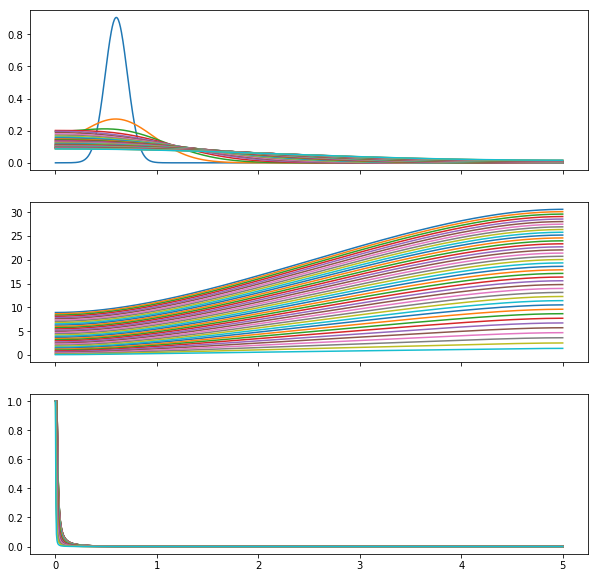

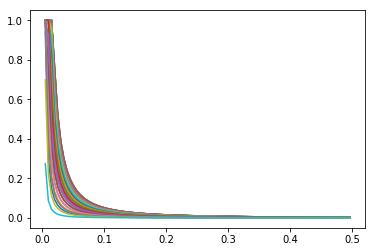

In [15]:
# Fixed point iteration

for it1 in np.arange(maxiter):

    fnew = SolveBoltzmann(ntsteps, x, dx, dt, fold, alphanew, sys1)
    [vnew, snew, alphanew] = SolveHJB(ntsteps, x, dx, dt, fnew, vold, sold, alphaold, alpha0, n, sys2)
   
    errorf = np.linalg.norm(fold-fnew)
    errorv = np.linalg.norm(vold-vnew)
    error = dt * dx * (errorf + errorv) 

    fold = fnew
    vold = vnew
    sold = snew
    alphaold = alphanew

    if error < 1e-6:
        break
    
print("Fixed point iteration stopped after ", it1, " iteration with an error of ", error)
print("final mass = ", np.trapz(fnew[ntsteps-1,:],x))

f, axarr = plt.subplots(3, sharex=True, figsize=(10,10))
axarr[0].plot(x, fnew.T[:,1:ntsteps-1:plotevery])
axarr[1].plot(x, vnew.T[:,1:ntsteps-1:plotevery])
axarr[2].plot(x, snew.T[:,1:ntsteps-1:plotevery])

plt.figure(2)
plt.plot(x[1:100],snew.T[1:100,1:ntsteps-1:plotevery])

plt.show()
